# **NOTEBOOK DO RELATÓRIO TÉCNICO**

Jupyter Notebook do **Projeto de Conclusão de Curso de Especialização em Inteligência Artificial e Aprendizagem de Máquina** da PUC MInas.

### **Aluno**: Wagner Evangelista de Abreu

### Pipeline do Projeto:
* Importação das Bibliotecas
* Leitura e Carregamento dos Dados
* Pré-processamento dos dados
* Análise Exploratória dos Dados <font color='yellow'>(Não implementado)</font>
* Construção do Modelo <font color='yellow'>(Não implementado)</font>
* Predições <font color='yellow'>(Não implementado)</font>
* Visualizações <font color='yellow'>(Não implementado)</font>
* Conclusão <font color='yellow'>(Não implementado)</font>

# Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import load_model # returns a compiled model
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Carregamento dos dados

In [2]:
# Procedimento para realizar a mesclagem dos arquivos 
def merge_files(
    input_folder, 
    output_folder, 
    output_file='output_',
    skiprows=0):
    # Mesclar os arquivos e exporta para uma pasta local
    import pandas as pd
    from os import listdir
    from os.path import isfile, join  

    # obtendo a lista de arquivos na pasta
    files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
    df_to_export = pd.DataFrame()

    # Varre todos arquivos da pasta
    for i in range(len(files)):
        complete_file_path = input_folder + files[i]
        # carregando o arquivo
        df = pd.read_csv(
            complete_file_path, 
            skiprows=skiprows, delimiter =';', 
            encoding="latin-1", 
            error_bad_lines = False
            )
        # Apaga colunas Unnamed
        df.drop(
            df.columns[df.columns.str.contains(
                'Unnamed', case=False)], 
                axis=1, inplace=True)
        
        # mesclando os arquivos
        df_to_export = pd.concat([df_to_export, df], ignore_index=True)

    df_to_export.drop_duplicates(keep = 'last', inplace = True)
    # Exportando arquivo
    df_to_export.to_csv(
        output_folder + output_file + '.csv', sep=';',
        index=None,
        header=True,
        encoding="utf-8"
    )

In [3]:
def filtering_data(
    dataframe, 
    campos_cidades=[],
    cidade_uf='',
    data_ref='data_inicio_viagem',
    ano_inicio=2007,
    ano_fim=2019):
    # Filtra o local de referência (origem ou destino) da viagem e retorna um dataframe Pandas
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior    
    # - campos_cidade (opcional): campo de referência contendo cidade e uf.
    #   Se não for fornecido, nenhum cidade é filtrada
    # - cidade_uf(opcional): nome e uf da cidade a ser filtrada
    #   Se não for fornecido, nenhum cidade é filtrada

    # Filtrando por ano de início
    dataframe = dataframe[pd.to_datetime(dataframe[data_ref]).dt.year >=ano_inicio]
    # Filtrando por ano de término
    dataframe = dataframe[pd.to_datetime(dataframe[data_ref]).dt.year <=ano_fim]
    # Eliminando registro em que data_inicio_viagem é vazia
    dataframe = dataframe[dataframe['data_inicio_viagem'].isna()==False]
    # Eliminando registro em que data_fim_viagem é vazia
    dataframe = dataframe[dataframe['data_fim_viagem'].isna()==False]
    # Eliminando registros em que a data de término seja anterior à data de início
    dataframe = dataframe[dataframe['data_inicio_viagem']<=dataframe['data_fim_viagem']]

    
    # Filtrando pelo campo e localidade de referência
    if len(campos_cidades) != 0:
        total_linhas = dataframe.shape[0]
        dataframe = \
            dataframe[(dataframe[campos_cidades['cidade']] == cidade_uf['cidade']) & (
                dataframe[campos_cidades['uf']] == cidade_uf['uf'])]
        percentual = np.round(dataframe.shape[0]/total_linhas*100, 2)
        print(f'Percentual de viagens filtradas: {percentual} %')
        
    return dataframe

def filling_missing_data(dataframe):
    # Checa se estão faltando datas no intervalo em estudo
    # e retorna um dataframe
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior

    # transnformando valores 0 da serie em NaN
    dataframe['total_passageiros'][dataframe['total_passageiros']==0] = np.nan
    
    # obtendo a lista de valores faltantes
    df_missing_data = dataframe[dataframe['total_passageiros'].isna()] 
    percentual = np.round(df_missing_data.shape[0]/dataframe.shape[0]*100, 2)
    print(f'Dados faltantes: {df_missing_data.shape[0]}')
    print(f'Total de linhas: {dataframe.shape[0]}')

    print(f'Percentual de dados faltantes: {percentual} %')
    print(df_missing_data)

    # preenchendo os valores faltantes com o método  interpolate 
    # e argumento method='time'
    dataframe = dataframe.interpolate(method='time').astype(int)
    
    del df_missing_data

    return dataframe

def groupby_day(dataframe, date_input):
    # Agrupa os dados por dia de acordo com o campo de data de final de referencia e 
    # retorna um dataframe
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior
    # - date_input: data de entrada (data_inicio_viagem, data_fim_viagem)

    # Se a date_input for igual a data_inicio_viagem a serie é obtida a série com base na origem da viagem
    # se a date_input for posterior a data_inicio_viagem, a série obtida baseia-se no destino da viagem

    # Transforma data_inicio_viagem e date_input em datetime
    dataframe['data_inicio_viagem'] = pd.to_datetime(
        dataframe['data_inicio_viagem'], infer_datetime_format=True)     
    dataframe[date_input] = pd.to_datetime(
        dataframe[date_input], infer_datetime_format=True)
    
    # Obtém a data de referência
    dataframe['dias'] = \
       (dataframe[date_input] - dataframe['data_inicio_viagem']).dt.days
    
    # Obtém a data no local de referencia
    dataframe['dias'] = dataframe['dias'].apply(lambda x: math.ceil(x/2))
    dataframe['data_ref'] = dataframe['data_inicio_viagem'] +\
         pd.to_timedelta(dataframe['dias'], unit='d')

    # Agrupa a série pela data de referência
    dataframe = dataframe.groupby(
       'data_ref', group_keys=False)["total_passageiros"].sum().reset_index()
    dataframe['index'] = dataframe['data_ref']
    dataframe = dataframe.set_index(['index'])  

    # Obtendo a série temporal diária 
    agg = {'total_passageiros':'sum'}
    dataframe = dataframe.resample('D', on='data_ref').agg(agg)

    return dataframe
    

def load_dataset(file_path):
    # Carrega o dataset e retorna um dataframe Pandas
    # Argumento:
    # - file_path: caminho do arquivo a ser carregado
    
    date_column = ['data_inicio_viagem', 'data_fim_viagem']
    dataframe = pd.read_csv(
        file_path, engine='python', delimiter=';', 
        parse_dates=date_column, dayfirst=True)    
    dataframe.drop_duplicates(inplace=True)

    return dataframe
    
def including_new_features(dataframe):
    # Inclui os atributos de feriado disponíveis no arquivo feriados_nacionais.csv e
    # retorna um dataframe Pandas 
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior

    # Carrega o arquivo contendo as datas com os feriados nacionais no período
    df_feriados = pd.read_csv(
        '../../dataset/raw/outros_atributos.csv',
        engine='python',
        delimiter=';')
    dataframe['data_ref'] = dataframe.index.to_series()

    # Transforma data_feriado em datetime
    df_feriados['data_feriado'] = pd.to_datetime(
        df_feriados['data_feriado'], format='%d/%m/%Y')   
           
    # Mescla os dataframes a partir da data de feriado
    dataframe = pd.merge(
        dataframe,
        df_feriados,
        left_index=True, right_on='data_feriado').drop(columns=['data_feriado'])   
    del df_feriados
    dataframe = dataframe.set_index(['data_ref'])  

    return dataframe    

def get_series(dataframe, periodicidade='D'):
    # Obtém a série temporalenriquecida e agregada por uma periodicidade e
    # retorna um dataframe Pandas 
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior
    # - periodicidade: 'D' - diária (default), 'W' - semanal, 'M' - mensal
    
    # Acrescenta uma coluna com uma nova feição: se a data é feriado ou não
    dataframe = including_new_features(dataframe)

    # Transforma a coluna de data de referência para o formato datetime
    dataframe['data_ref'] = pd.to_datetime(
        dataframe.index.to_series(), infer_datetime_format=True)    

    # Define os atributos de agregação
    agg = {
        'total_passageiros':'sum',
        'feriado':'sum',
        'doze_outubro':'sum',
        'papa_aparecida':'sum'}
    # Obtém o dataframe agregado de acordo com a periodicidade definida
    dataframe = dataframe.resample(periodicidade).agg(agg)             

    # Se a periodicidade for diária, transforma o índice em uma coluna datetime e 
    # obtém o dia da semana (0-domingo, 1-segunda-feira, 2-terça-feira, 3-quarta-feira, 
    # 4-quinta-feira, 5-sexta-feira, 6-sábado)
    if periodicidade == 'D':
        date_series = pd.to_datetime(
                dataframe.index.to_series(), infer_datetime_format=True)         
        dataframe['dia_semana'] = date_series.dt.dayofweek                


    # Se periodicidade é mensal, obtém a série configando o indice como ano/mês
    if periodicidade == 'M':
        dataframe = dataframe.set_index(dataframe.index.strftime('%Y/%m'))        

    return dataframe    
    

In [4]:
# Periodicidade da série ('M' - mensal; 'W' - semanal; e 'D' - diária)
periodicidade = 'D'

# Campos de referência das localidades:
# - município: municipio_origem, municipiodestino; e
# - uf: uf_municipio_origem, uf_municipio_destino.
campos_cidades = {'cidade': 'municipiodestino', 'uf': 'uf_municipio_destino'}

# Cidade e UF de referência
cidade_uf = {'cidade': 'APARECIDA', 'uf': 'SP'}

# Data de referência (data_inicio_viagem; data_fim_viagem)
data_ref = 'data_fim_viagem'

# Caminho completo do arquivo
arquivo = '../../dataset/raw/data_fret.csv'
data = (
    load_dataset(arquivo)  # carregamento dos dados
    .pipe(filtering_data, campos_cidades, cidade_uf, data_ref, 2007, 2019)  # filtragem do local de referência
    .pipe(groupby_day, data_ref)  # agrupamento pela data de referência
    .pipe(filling_missing_data)  # preenchendo valores faltantes
    .pipe(get_series, periodicidade)  # obtém a série temporal finals
)

Dados faltantes: 9
Total de linhas: 4770
Percentual de dados faltantes: 0.19 %
            total_passageiros
data_ref                     
2020-01-09                NaN
2020-01-10                NaN
2020-01-11                NaN
2020-01-12                NaN
2020-01-17                NaN
2020-01-18                NaN
2020-01-19                NaN
2020-01-20                NaN
2020-01-21                NaN


# Análise Exploratória de Dados

In [6]:
def plot_series(data, axis_x):
    dataset = pd.DataFrame(data.values)
    groups = dataset.columns
    column_names = data.columns
    i = 1
    fig = plt.figure();
    fig.tight_layout();
    plt.figure(figsize=(12, 12));
    for group in groups:
        plt.subplot(len(groups), 1, i, );
        plt.plot(pd.to_datetime(axis_x), data.values[:, group]);
        plt.xticks(rotation=90);
        plt.title(column_names[group], y=1, loc='left', pad=-60)
        plt.title(column_names[group], loc='left', pad=-80);
        i += 1
        plt.subplots_adjust(hspace = 0.5)
        fig.tight_layout();
    plt.show();
    plt.tight_layout();

<Figure size 432x288 with 0 Axes>

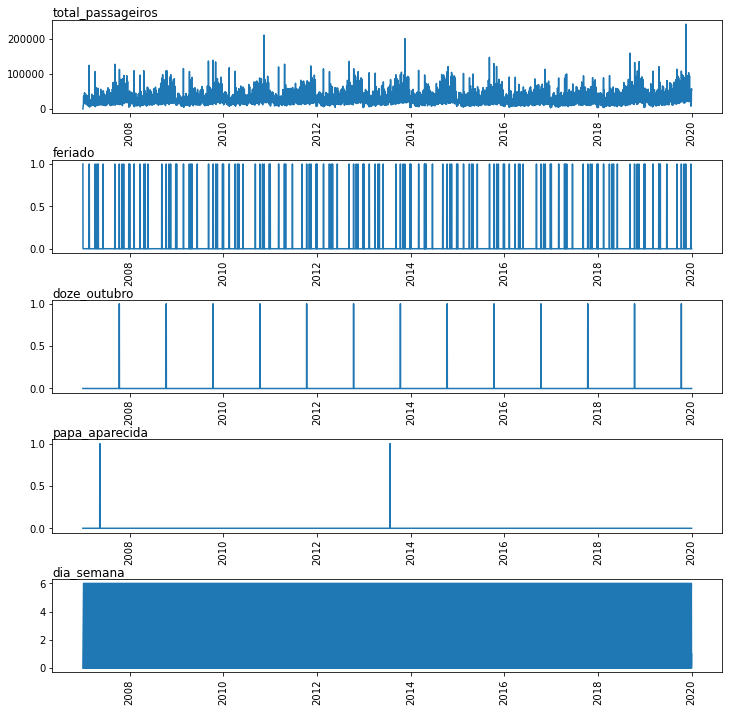

<Figure size 432x288 with 0 Axes>

In [7]:
plot_series(data, data.index.values);